In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras_vggface.vggface import VGGFace
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

In [2]:
# Load LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=True)

In [3]:
# Extract features and labels
X = lfw_dataset.images
y = lfw_dataset.target
target_names = lfw_dataset.target_names

In [4]:
# Resize images to match expected input size of the vggface Model (224, 224)
X_resized = np.array([resize(image, (224, 224)) for image in X])

In [5]:
# Normalize pixel values to range [0, 1]
X_rescaled = X_resized / 255.0

In [6]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [7]:
resnet50_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))
last_layer = resnet50_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(len(target_names), activation='softmax', name='classifier')(x)
model = Model(resnet50_model.input, out)

In [8]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Configure K-Fold Cross-Validation
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [10]:
# Initialize lists to store true positive rates and area under curve values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
# Initialize list to store fold accuracies
fold_accs = []
# Initialize lists to store precision, recall, f1-score, and confusion matrices
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
# Training and Evaluation Loop

for fold, (train_index, val_index) in enumerate(skf.split(X_rescaled, y)):
    print(f"Fold {fold+1}/{num_folds}")
    X_train, X_val = X_rescaled[train_index], X_rescaled[val_index]
    y_train, y_val = y_categorical[train_index], y_categorical[val_index]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val)
    fold_accs.append(accuracy)

    # Compute predicted probabilities
    y_prob = model.predict(X_val)
    y_pred = np.argmax(y_prob, axis=1)

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_val[:, 1], y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Interpolate tpr to match mean_fpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)

    # Append tpr and auc to lists
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

    # Compute precision, recall, f1-score, and confusion matrix
    precision = precision_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

    # Append precision, recall, f1-score, and confusion matrix to lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

Fold 1/10
Epoch 1/10
37/37 [==============================] - 32s 276ms/step - loss: 3.0639 - accuracy: 0.3589 - val_loss: 109193224.0000 - val_accuracy: 0.0543
Epoch 2/10
37/37 [==============================] - 9s 235ms/step - loss: 1.7355 - accuracy: 0.4003 - val_loss: 7858.2124 - val_accuracy: 0.0543
Epoch 3/10
37/37 [==============================] - 9s 236ms/step - loss: 1.6189 - accuracy: 0.4409 - val_loss: 34.4337 - val_accuracy: 0.1860
Epoch 4/10
37/37 [==============================] - 9s 237ms/step - loss: 1.4921 - accuracy: 0.4737 - val_loss: 1.9313 - val_accuracy: 0.1860
Epoch 5/10
37/37 [==============================] - 9s 236ms/step - loss: 1.2723 - accuracy: 0.5496 - val_loss: 2.0645 - val_accuracy: 0.1860
Epoch 6/10
37/37 [==============================] - 9s 235ms/step - loss: 1.0948 - accuracy: 0.6109 - val_loss: 2.9375 - val_accuracy: 0.1860
Epoch 7/10
37/37 [==============================] - 9s 236ms/step - loss: 0.9477 - accuracy: 0.6609 - val_loss: 69.4593 - val

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 9s 240ms/step - loss: 0.2819 - accuracy: 0.8982 - val_loss: 6.6379 - val_accuracy: 0.0620
Epoch 2/10
37/37 [==============================] - 9s 236ms/step - loss: 0.2480 - accuracy: 0.9154 - val_loss: 6.1989 - val_accuracy: 0.0620
Epoch 3/10
37/37 [==============================] - 9s 236ms/step - loss: 0.1868 - accuracy: 0.9396 - val_loss: 5.5125 - val_accuracy: 0.0620
Epoch 4/10
37/37 [==============================] - 9s 236ms/step - loss: 0.1131 - accuracy: 0.9646 - val_loss: 12.1037 - val_accuracy: 0.0620
Epoch 5/10
37/37 [==============================] - 9s 236ms/step - loss: 0.1043 - accuracy: 0.9664 - val_loss: 23.7087 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0606 - accuracy: 0.9827 - val_loss: 13.3812 - val_accuracy: 0.0620
Epoch 7/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0278 - accuracy: 0.9948 - val_loss: 4.6377 - val_accuracy: 0.0620
Epo

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 9s 237ms/step - loss: 0.1154 - accuracy: 0.9612 - val_loss: 9.5049 - val_accuracy: 0.0620
Epoch 2/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0809 - accuracy: 0.9750 - val_loss: 3.1530 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0574 - accuracy: 0.9827 - val_loss: 13.0456 - val_accuracy: 0.0543
Epoch 4/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0282 - accuracy: 0.9914 - val_loss: 12.8610 - val_accuracy: 0.0620
Epoch 5/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0248 - accuracy: 0.9914 - val_loss: 11.7207 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0153 - accuracy: 0.9940 - val_loss: 6.3456 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 9s 241ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 9.0296 - val_accuracy: 0.4109
Epo

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 9s 237ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 3.2254 - val_accuracy: 0.4186
Epoch 2/10
37/37 [==============================] - 9s 235ms/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 3.3409 - val_accuracy: 0.4264
Epoch 3/10
37/37 [==============================] - 9s 235ms/step - loss: 0.0341 - accuracy: 0.9888 - val_loss: 3.4784 - val_accuracy: 0.1628
Epoch 4/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0266 - accuracy: 0.9931 - val_loss: 4.4265 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 9s 235ms/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 10.9912 - val_accuracy: 0.1163
Epoch 6/10
37/37 [==============================] - 9s 235ms/step - loss: 0.0241 - accuracy: 0.9940 - val_loss: 5.0811 - val_accuracy: 0.4574
Epoch 7/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 5.4825 - val_accuracy: 0.4186
Epoch

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 9s 237ms/step - loss: 0.1504 - accuracy: 0.9534 - val_loss: 25.1440 - val_accuracy: 0.1783
Epoch 2/10
37/37 [==============================] - 9s 235ms/step - loss: 0.2247 - accuracy: 0.9180 - val_loss: 30.2603 - val_accuracy: 0.0620
Epoch 3/10
37/37 [==============================] - 9s 235ms/step - loss: 0.0449 - accuracy: 0.9862 - val_loss: 11.8019 - val_accuracy: 0.0620
Epoch 4/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0235 - accuracy: 0.9940 - val_loss: 16.2653 - val_accuracy: 0.0620
Epoch 5/10
37/37 [==============================] - 9s 235ms/step - loss: 0.1014 - accuracy: 0.9646 - val_loss: 2.5395 - val_accuracy: 0.2558
Epoch 6/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0404 - accuracy: 0.9879 - val_loss: 35.0109 - val_accuracy: 0.0620
Epoch 7/10
37/37 [==============================] - 9s 236ms/step - loss: 0.0306 - accuracy: 0.9914 - val_loss: 26.4612 - val_accuracy: 0.0620


Normalized confusion matrix


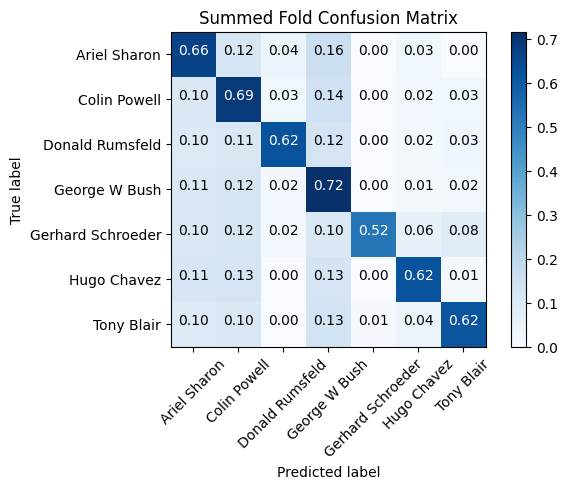

In [13]:
# Plot the summed confusion matrix
sum_conf_matrix = np.sum(conf_matrices, axis=0)
plt.figure()
plot_confusion_matrix(sum_conf_matrix, classes=target_names, normalize=True,
                      title='Summed Fold Confusion Matrix')

In [14]:
# Compute mean accuracy, precision, recall, f1-score
mean_accuracy = np.mean(fold_accs)
mean_precisions = np.mean(precisions)
mean_recalls = np.mean(recalls)
mean_f1_scores = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precisions: {mean_precisions}")
print(f"Mean Recalls: {mean_recalls}")
print(f"Mean F1 Score: {mean_f1_scores}")

Mean Accuracy: 0.6666484925895929
Mean Precisions: 0.6382974633424638
Mean Recalls: 0.6666484980620154
Mean F1 Score: 0.6295579961501325


In [15]:
# Print precision, recall, f1-score, and confusion matrix for each fold
for i in range(num_folds):
    print(f"\nFold {i+1}:")
    print(f"Precision: {precisions[i]}")
    print(f"Recall: {recalls[i]}")
    print(f"F1-Score: {f1_scores[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])


Fold 1:
Precision: 0.0029445345832582177
Recall: 0.05426356589147287
F1-Score: 0.005585955312357501
Confusion Matrix:
[[ 7  0  0  0  0  0  0]
 [24  0  0  0  0  0  0]
 [12  0  0  0  0  0  0]
 [53  0  0  0  0  0  0]
 [11  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0]
 [14  0  0  0  0  0  0]]

Fold 2:
Precision: 0.03178895499068566
Recall: 0.17829457364341086
F1-Score: 0.05395756833945328
Confusion Matrix:
[[ 0  8  0  0  0  0  0]
 [ 0 23  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0 53  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  7  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]]

Fold 3:
Precision: 0.2631419573643411
Recall: 0.4186046511627907
F1-Score: 0.2549211463511861
Confusion Matrix:
[[ 0  0  0  8  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  1 11  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0 11  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0 15  0  0  0]]

Fold 4:
Precision: 0.2889098362838921
Recall: 0.3488372093023256
F1-Score: 0.29626900556570024
Confusion Matrix:
[[ 0  0  3  4  0  1  0]
 [ 0  0

In [16]:
# Compute mean and standard deviation of tpr
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

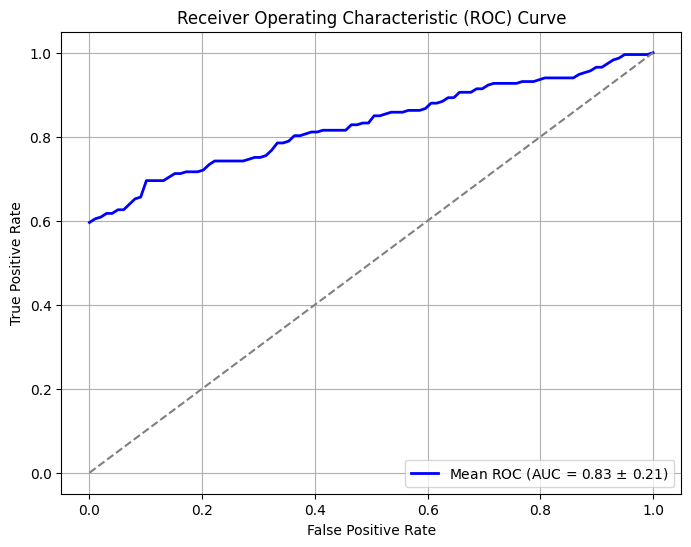

In [17]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()